** 스마트워치 센서 데이터 기반 행동 분류 3일차 **
# --------- 미션6 : 행동 추론 ---------

### (0) 미션 이해하기
   * 단말기 개발팀에서 Fine Watch에 헬스케어 기능을 추가 할 수있도록, 스마트워치에서 수집하는 데이터를 분석해 행동을 분류할 수 있는 AI 모델과 중요 Future list를 전달해야 합니다.
   * test 데이터셋에서 6가지 행동분류 중 'WALKING_UPSTAIRS'를 분류하는 모델을 만들고 정확도 도출해 보세요.
   * 마지막으로 누적된 모델의 정확도(result)와 'WALKING_UPSTAIRS' 행동분류 중요 Feature 5개의 정보를 개발팀으로 전달해 주세요.
   

<span style="background-color:#fff5b1"><span style="color:black"><U>※ 미션완수 조건: 헬스케어 기능 개발을 위해 '계단 오르기' 행동분류를 위한 모델을 만들고 정확도와 데이터를 시각화 하세요.<U></span></span>

<span style="background-color:#fff5b1"><span style="color:red"><U>※ 함수/변수명, 데이터 타입 잘 확인하고 코드를 작성하세요 <U></span></span>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import seaborn as sns
import os


from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import warnings
warnings.filterwarnings(action='ignore')
%config InlineBackend.figure_format = 'retina'

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report


### (1) 데이터 불러오기

	- 실습순서: 라이브러리 불러오기 -> 현재 디렉토리 확인 -> train_data.csv 불러오기 -> 'subject' 제거 -> result5.csv 불러오기

In [2]:
# pandas, numpy, matplotlib, seaborn, os 등 필요 라이브러리 호출
# 데이터를 나누기 위한 sklearn.model_selection 모듈의 train_test_split 함수 사용
# 모델 성능 평가 출력을 위해 sklearn.metrics 모듈의 모든 클래스 사용




* test 데이터 불러오기

In [3]:
# 'data' 폴더에서 test_data.csv 파일을 불러와서 data 변수에 할당
# 잘 할당 되었는지 상위 5개행 데이터 확인



In [4]:
# data 변수(데이터셋)에서 행동분류에 불필요한 'subject'열 제거
# 'subject'열이 잘 제거 되었는지 확인




In [5]:
data = pd.read_csv('test_data.csv')

# data 변수(데이터셋)에서 행동분류에 불필요한 'subject'열 제거
# 'subject'열이 잘 제거 되었는지 확인

data.drop('subject', axis=True, inplace=True)



* result 데이터 불러오기

In [6]:
# 모델별 정확도를 비교 할 수 있도록 결과 저장 파일 호출 
# result 변수에 'data' 폴더에서 /result5.csv 파일을 불러와서 할당
# 잘 불러와 졌는지 확인

result = pd.read_csv('result5.csv')
result

,data,model_name,accuracy_score,f1_score
0,train,svc,0.968839,0.971715
1,train,KNN,0.954674,0.958345
2,train,LR,0.983003,0.984583
3,train,GBM,0.981870,0.983141
4,train,xgb,0.990368,0.991052
5,train,xgb_hpt,0.991501,0.992355
6,train,xgb95_hpt,0.992068,0.992371
7,train,xgb50_hpt,0.988669,0.988601
8,train,xgb_top_model,0.992635,0.993060
9,test,xgb_hpt,0.970588,0.971003


### (2) 'WALKING_UPSTAIRS' 행동분류에 사용할 feature 중요도 도출을 위한 모델링
* 'WALKING_UPSTAIRS' 행동분류의 feature 중요도를 도출하기 전 사전 모델링을 시행 하세요


	- 실습순서: 라이브러리 호출-> 데이터 분할 -> 데이터 가공 -> 모델링 -> 결과 출력

In [7]:
# x, y 데이터 나누기 (target = 'Activity')

# x, y 데이터 나누기 (target = 'Activity')

y = data['Activity']
x = data.drop('Activity', axis=1)
x_train, x_val, y_train, y_val = train_test_split(x,y,train_size=0.7,random_state=2023)



* 'WALKING_UPSTAIRS' 분류를 위한 맵핑

In [8]:
# XGBoost 는 문자형 데이터로 학습할 수 없습니다. 
# y_map 변수를 생성해서 target 데이터(y)를 숫자형 형태로 치환하여 할당
# 데이터 치환 함수: map
# 치환 데이터: 'STANDING':0, 'SITTING':0, 'LAYING':0, 'WALKING':0, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':0

map_dATA={'STANDING':0, 'SITTING':0, 'LAYING':0, 'WALKING':0, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':0}

y_map=y.map(map_dATA)


In [9]:
# x,y_map를 사용하여 학습 데이터 분할 비율: 학습데이터 7 : 검증데이터 3
# random_state=2023

x_train,x_val,y_map_train,y_map_val=train_test_split(x,y_map,test_size=0.3,random_state=2023)



* 'WALKING_UPSTAIRS' 행동분류 모델링

In [10]:
# 베스트 파라미터를 적용한 xgb 모델 초기화, 학습, 예측
# AI모델 변수명: up_xgb_model 예측결과 변수명: up_xgb_pred
# random_state=2023

up_xgb_model = XGBClassifier(random_state=2023, max_depth = 3 , learning_rate = 0.3)

# 학습하기
up_xgb_model.fit(x_train, y_map_train)

# 예측하기
up_xgb_pred = up_xgb_model.predict(x_val)



In [11]:
# 모델 평가 출력(accuracy_score, confusion_matrix, classification_report)

print('accuracy_score: ',accuracy_score(y_map_val,up_xgb_pred))
print('\n confusion_matrix: \n',confusion_matrix(y_map_val,up_xgb_pred))
print('\n classification_report: \n',classification_report(y_map_val,up_xgb_pred))


accuracy_score:  0.9909502262443439

 confusion_matrix: 
 [[375   0]
 [  4  63]]

 classification_report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       375
           1       1.00      0.94      0.97        67

    accuracy                           0.99       442
   macro avg       0.99      0.97      0.98       442
weighted avg       0.99      0.99      0.99       442



In [12]:
result.loc[11] = ['test', 'up_xgb', accuracy_score(y_map_val,up_xgb_pred), f1_score(y_map_val,up_xgb_pred,average='macro')]
result

,data,model_name,accuracy_score,f1_score
0,train,svc,0.968839,0.971715
1,train,KNN,0.954674,0.958345
2,train,LR,0.983003,0.984583
3,train,GBM,0.981870,0.983141
4,train,xgb,0.990368,0.991052
5,train,xgb_hpt,0.991501,0.992355
6,train,xgb95_hpt,0.992068,0.992371
7,train,xgb50_hpt,0.988669,0.988601
8,train,xgb_top_model,0.992635,0.993060
9,test,xgb_hpt,0.970588,0.971003


In [13]:
# result 변수에 result 변수(데이터프레임) 마지막에 모델 평가 결과 추가 
# 할당할 정보는 데이터명('test'), 모델명('up_xgb'), 'accuracy_score', 'f1_score' 예측 결과 할당
# 정확히 구성되었나 확인




### (3) 'WORKING_UPSTAIRS' 행동분류 모델 Feature Selection
* WORKING_UPSTAIRS을 분류한 모델에 영향을 미친 중요 feature를 찾고 상위 5개 feature의 데이터에 대해 시각화를 합니다.

	- 실습순서: 중요도 데이터프레임 생성-> 데이터 분할/가공 -> 최적의 Feature Selection 찾기 -> 상위 5개 feature 데이터 시각화 -> 센서별 중요도 시각화 

* 변수별 중요도 추출

In [14]:
# importance_sort 데이터프레임 변수 생성 초기화

importance_data = pd.DataFrame()

In [15]:
# importance_sort['feature_name'] 열에 모델링에 사용한 x 데이터프레임의 컬럼명을 할당
importance_data['feature_name'] = x.columns


In [17]:
# importance_sort['feature_importance'] 열에 앞에서 사용한 xgb_hpt_up_model 모델의 feature_importances 를 할당
# 참고함수: feature_importances_

importance_data['feature_importance'] = up_xgb_model.feature_importances_
importance_data

,feature_name,feature_importance
0,tBodyAcc-mean()-X,0.003518
1,tBodyAcc-mean()-Y,0.000119
2,tBodyAcc-mean()-Z,0.000000
3,tBodyAcc-std()-X,0.000000
4,tBodyAcc-std()-Y,0.000000
...,...,...
556,"angle(tBodyGyroMean,gravityMean)",0.000221
557,"angle(tBodyGyroJerkMean,gravityMean)",0.000000
558,"angle(X,gravityMean)",0.000000
559,"angle(Y,gravityMean)",0.009788


In [18]:
#강사


In [19]:
# importance_sort['feature_importance'] 를 내림차순 정열(기준열='feature_importance', 내림차순)
# 참고함수: sort_values
importance_sort = importance_data.sort_values(by='feature_importance', ascending=False)
importance_sort

,feature_name,feature_importance
330,"fBodyAcc-bandsEnergy()-1,8.2",0.161816
228,tBodyAccJerkMag-mad(),0.094476
73,"tGravityAcc-arCoeff()-Z,1",0.090941
516,fBodyBodyAccJerkMag-std(),0.075896
316,"fBodyAcc-bandsEnergy()-1,8.1",0.068309
...,...,...
213,tGravityAccMag-mean(),0.000000
212,tBodyAccMag-arCoeff()4,0.000000
208,tBodyAccMag-entropy(),0.000000
207,tBodyAccMag-iqr(),0.000000


In [20]:
# 강사

In [21]:
# feature_importance 내림차순 정렬 때문에 엉킨 인덱스 재설정
# 참고함수: reset_index
# 파라미터: drop=True, inplace=True
# 제대로 정렬 되었는지 데이터 프레임에 확인
importance_sort.reset_index(inplace=True, drop=True)
importance_sort

,feature_name,feature_importance
0,"fBodyAcc-bandsEnergy()-1,8.2",0.161816
1,tBodyAccJerkMag-mad(),0.094476
2,"tGravityAcc-arCoeff()-Z,1",0.090941
3,fBodyBodyAccJerkMag-std(),0.075896
4,"fBodyAcc-bandsEnergy()-1,8.1",0.068309
...,...,...
556,tGravityAccMag-mean(),0.000000
557,tBodyAccMag-arCoeff()4,0.000000
558,tBodyAccMag-entropy(),0.000000
559,tBodyAccMag-iqr(),0.000000


In [22]:

#강사


* Feature Selection 을 반복적으로 적용해 최고 정확도의 중요 feature 개수 학습 결과 선별

In [23]:

acc = pd.DataFrame(columns=['accuracy_score'])

for i in range(130):

    importance_n = importance_sort['feature_name'][:i+1]

    x_train_n = x_train[importance_n]
    x_val_n = x_val[importance_n]

    xgb_n_model = XGBClassifier(learning_rate=0.3, max_depth=3, random_state=2023)
    xgb_n_model.fit(x_train_n, y_map_train)
    xgb_n_pred = xgb_n_model.predict(x_val_n)
    
    acc.loc[i] = accuracy_score(y_map_val,xgb_n_pred)
    print(acc.loc[i])

acc

accuracy_score    0.866516
Name: 0, dtype: float64
accuracy_score    0.920814
Name: 1, dtype: float64
accuracy_score    0.936652
Name: 2, dtype: float64
accuracy_score    0.947964
Name: 3, dtype: float64
accuracy_score    0.959276
Name: 4, dtype: float64
accuracy_score    0.961538
Name: 5, dtype: float64
accuracy_score    0.954751
Name: 6, dtype: float64
accuracy_score    0.972851
Name: 7, dtype: float64
accuracy_score    0.972851
Name: 8, dtype: float64
accuracy_score    0.975113
Name: 9, dtype: float64
accuracy_score    0.9819
Name: 10, dtype: float64
accuracy_score    0.988688
Name: 11, dtype: float64
accuracy_score    0.995475
Name: 12, dtype: float64
accuracy_score    0.993213
Name: 13, dtype: float64
accuracy_score    0.984163
Name: 14, dtype: float64
accuracy_score    0.99095
Name: 15, dtype: float64
accuracy_score    0.99095
Name: 16, dtype: float64
accuracy_score    0.986425
Name: 17, dtype: float64
accuracy_score    0.99095
Name: 18, dtype: float64
accuracy_score    0.988688


,accuracy_score
0,0.866516
1,0.920814
2,0.936652
3,0.947964
4,0.959276
...,...
125,0.990950
126,0.990950
127,0.990950
128,0.990950


In [24]:
# acc 데이터 프레임을 생성 및 초기화(컬럼 지정: columns=['accuracy_score'])
# for 문을 사용해 중요도 상위 feature 1개 모델링부터 상위 feature 100개  모델링까지 순차적 모델링 실행 후 각 accuracy_score 결과를 acc 변수에 누적
# 전체 feature는 561개 이지만, 학습에 130개면 충분(약 10분 소요)
# for 매 회 마다 결과 출력



<Figure size 1000x800 with 0 Axes>

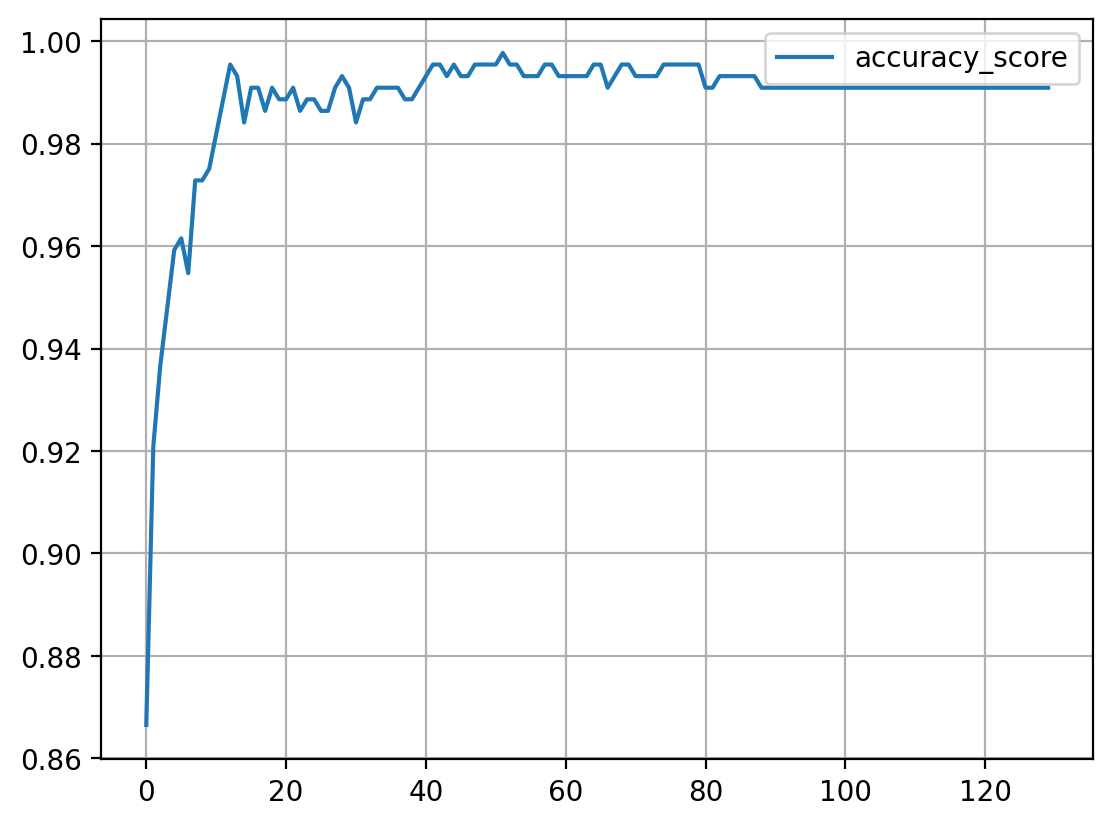

In [25]:
plt.figure(figsize=(10,8))
acc.plot()
plt.grid()
plt.show()

In [26]:
# accuracy_score 누적한 acc 변수 시각화
## 참고 함수: plt.plot




* 정확도 최고의 학습 Feature 개수 찾기

In [27]:
# acc 변수를 accuracy_score 기준 내림차순으로 정렬(인덱스 재설정X)
# accuracy_score 값이 가장 높을때의 인덱스명이 학습된 상위 feature 개수를 뜻함
acc = acc.sort_values(by='accuracy_score', ascending=False)
acc

,accuracy_score
51,0.997738
65,0.995475
58,0.995475
47,0.995475
48,0.995475
...,...
6,0.954751
3,0.947964
2,0.936652
1,0.920814


In [28]:
importance_top = importance_sort['feature_name'][:acc.index[0]+1]
importance_top

0       fBodyAcc-bandsEnergy()-1,8.2
1              tBodyAccJerkMag-mad()
2          tGravityAcc-arCoeff()-Z,1
3          fBodyBodyAccJerkMag-std()
4       fBodyAcc-bandsEnergy()-1,8.1
5         tBodyAcc-correlation()-X,Y
6                  tBodyAccMag-std()
7                fBodyGyro-maxInds-Z
8                   fBodyAcc-max()-Z
9               tBodyGyro-energy()-X
10         tGravityAcc-arCoeff()-Y,2
11               tGravityAcc-min()-Y
12                  fBodyAcc-max()-X
13         fBodyAccJerk-meanFreq()-X
14             fBodyAcc-meanFreq()-Z
15                  tBodyAcc-max()-X
16         fBodyAccJerk-kurtosis()-Z
17        fBodyAcc-bandsEnergy()-1,8
18    fBodyBodyAccJerkMag-skewness()
19              tGravityAcc-mean()-Y
20              fBodyAccJerk-mad()-Z
21              angle(Y,gravityMean)
22                tBodyGyro-mean()-X
23    tBodyAccJerk-correlation()-X,Y
24    fBodyAcc-bandsEnergy()-17,32.2
25              tBodyAccJerk-max()-X
26        tBodyAcc-correlation()-X,Z
2

In [30]:
# importance_top 변수에 acc 에서 확인한 상위 feature 개수 만큼 importance_sort['feature_name']를 슬라이싱 하여 할당
# 참고: 슬라이싱 할때 [:1] -> index 0 까지 짤림, [:100] -> index 99 까지 짤림, 정확도 최고치 인덱스 값 +1 해서 슬라이싱 할것

In [31]:
# 훈련 데이터 생성
# x_train_top 변수에 x_train을 중요 feature 만클 슬라이싱 한 x_train[importance_top] 할당
# x_val_top 변수에 x_val을 중요 feature 만클 슬라이싱 한 x_val[importance_top] 할당


x_train_top = x_train[importance_top]
x_val_top = x_val[importance_top]



In [72]:
# XGBClassifier 모델 초기화,학습,예측
# AI모델 변수명: up_xgb_top_model , 예측결과 변수명: up_xgb_top_pred
# random_state=2023



up_xgb_top_model = XGBClassifier(random_state=2023, max_depth = 3 , learning_rate = 0.3)

# 학습하기
up_xgb_top_model.fit(x_train_top, y_map_train)

# 예측하기
up_xgb_top_pred = up_xgb_top_model.predict(x_val_top)



In [73]:
# 모델 평가 출력(accuracy_score, confusion_matrix, classification_report)

print('accuracy_score: ',accuracy_score(y_map_val,up_xgb_top_pred))
print('\n confusion_matrix: \n',confusion_matrix(y_map_val,up_xgb_top_pred))
print('\n classification_report: \n',classification_report(y_map_val,up_xgb_top_pred))

accuracy_score:  0.997737556561086

 confusion_matrix: 
 [[375   0]
 [  1  66]]

 classification_report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       375
           1       1.00      0.99      0.99        67

    accuracy                           1.00       442
   macro avg       1.00      0.99      1.00       442
weighted avg       1.00      1.00      1.00       442



In [74]:
# 모델 평가 출력(accuracy_score, confusion_matrix, classification_report)





In [75]:
result.loc[12] = ['test', 'up_xgb_top', accuracy_score(y_map_val,up_xgb_top_pred), f1_score(y_map_val,up_xgb_top_pred,average='macro')]
result

,data,model_name,accuracy_score,f1_score
0,train,svc,0.968839,0.971715
1,train,KNN,0.954674,0.958345
2,train,LR,0.983003,0.984583
3,train,GBM,0.981870,0.983141
4,train,xgb,0.990368,0.991052
5,train,xgb_hpt,0.991501,0.992355
6,train,xgb95_hpt,0.992068,0.992371
7,train,xgb50_hpt,0.988669,0.988601
8,train,xgb_top_model,0.992635,0.993060
9,test,xgb_hpt,0.970588,0.971003


In [76]:
# result 변수에 result 변수(데이터프레임) 마지막에 모델 평가 결과 추가 
# 할당할 정보는 데이터명('test'), 모델명('up_xgb_top'), 'accuracy_score', 'f1_score' 예측 결과 할당
# 정확히 구성되었나 확인



In [77]:
importance_sort = importance_data.sort_values(by='feature_importance', ascending=False)
importance_sort

,feature_name,feature_importance
330,"fBodyAcc-bandsEnergy()-1,8.2",0.161816
228,tBodyAccJerkMag-mad(),0.094476
73,"tGravityAcc-arCoeff()-Z,1",0.090941
516,fBodyBodyAccJerkMag-std(),0.075896
316,"fBodyAcc-bandsEnergy()-1,8.1",0.068309
...,...,...
213,tGravityAccMag-mean(),0.000000
212,tBodyAccMag-arCoeff()4,0.000000
208,tBodyAccMag-entropy(),0.000000
207,tBodyAccMag-iqr(),0.000000


In [78]:

importance_sort.reset_index(inplace=True, drop=True)
importance_sort

,feature_name,feature_importance
0,"fBodyAcc-bandsEnergy()-1,8.2",0.161816
1,tBodyAccJerkMag-mad(),0.094476
2,"tGravityAcc-arCoeff()-Z,1",0.090941
3,fBodyBodyAccJerkMag-std(),0.075896
4,"fBodyAcc-bandsEnergy()-1,8.1",0.068309
...,...,...
556,tGravityAccMag-mean(),0.000000
557,tBodyAccMag-arCoeff()4,0.000000
558,tBodyAccMag-entropy(),0.000000
559,tBodyAccMag-iqr(),0.000000


In [79]:
importance_sort_5 = importance_sort.head()

* 상위 5 feature의 데이터 저장 및 시각화 

In [80]:
# 상위 1~5위 feature_name 확인
importance_sort_5



,feature_name,feature_importance
0,"fBodyAcc-bandsEnergy()-1,8.2",0.161816
1,tBodyAccJerkMag-mad(),0.094476
2,"tGravityAcc-arCoeff()-Z,1",0.090941
3,fBodyBodyAccJerkMag-std(),0.075896
4,"fBodyAcc-bandsEnergy()-1,8.1",0.068309


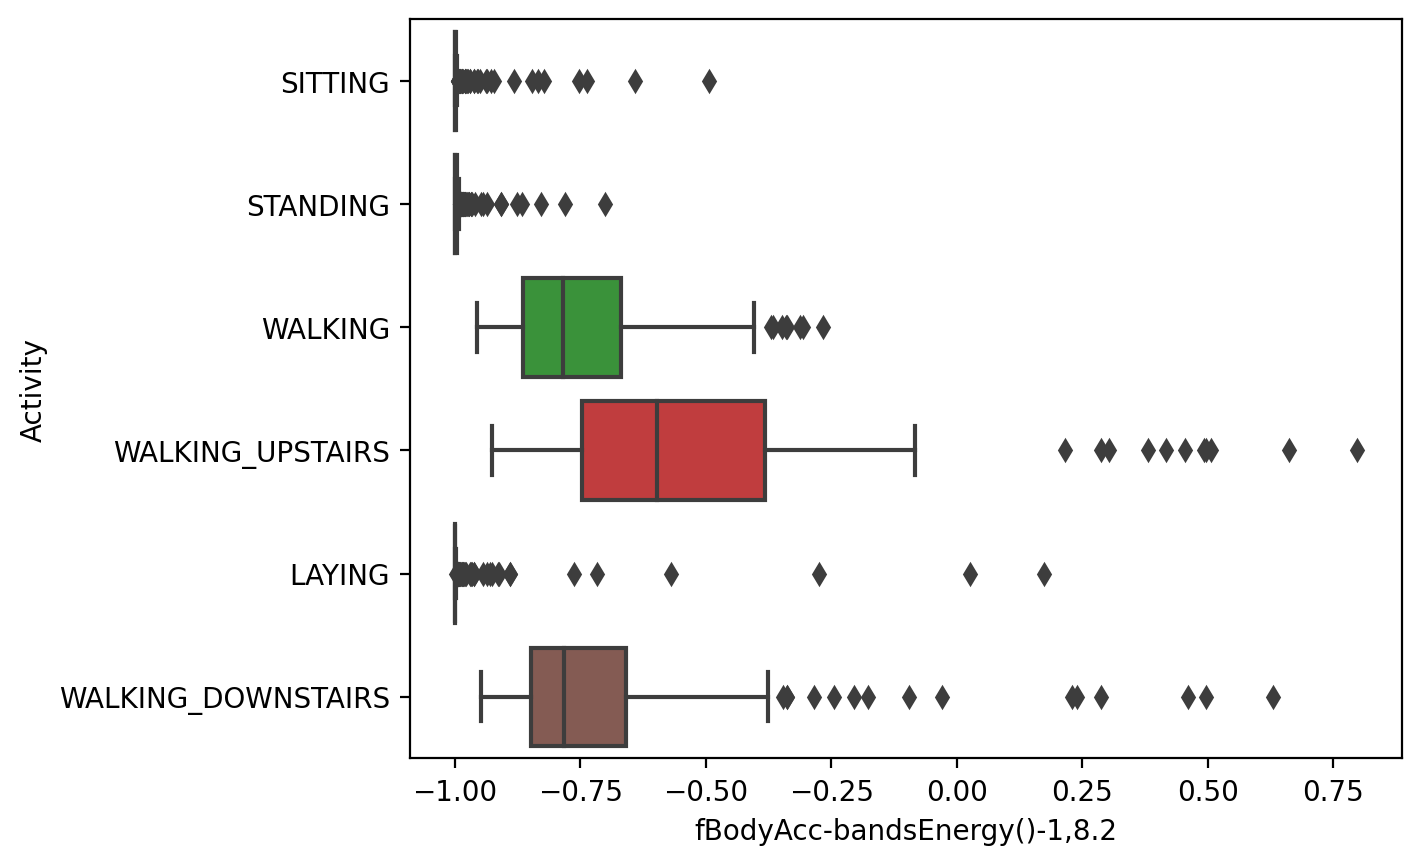

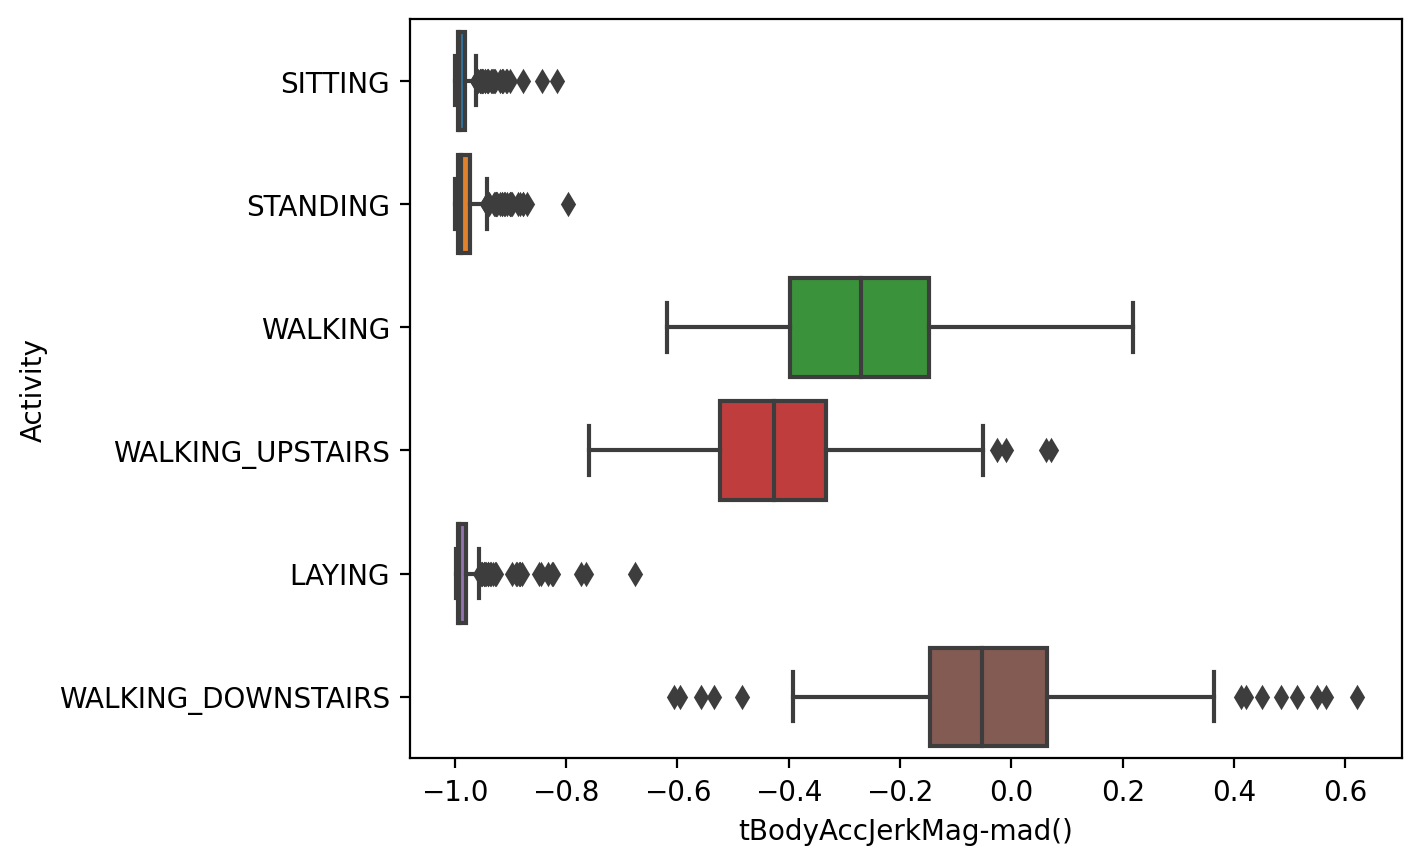

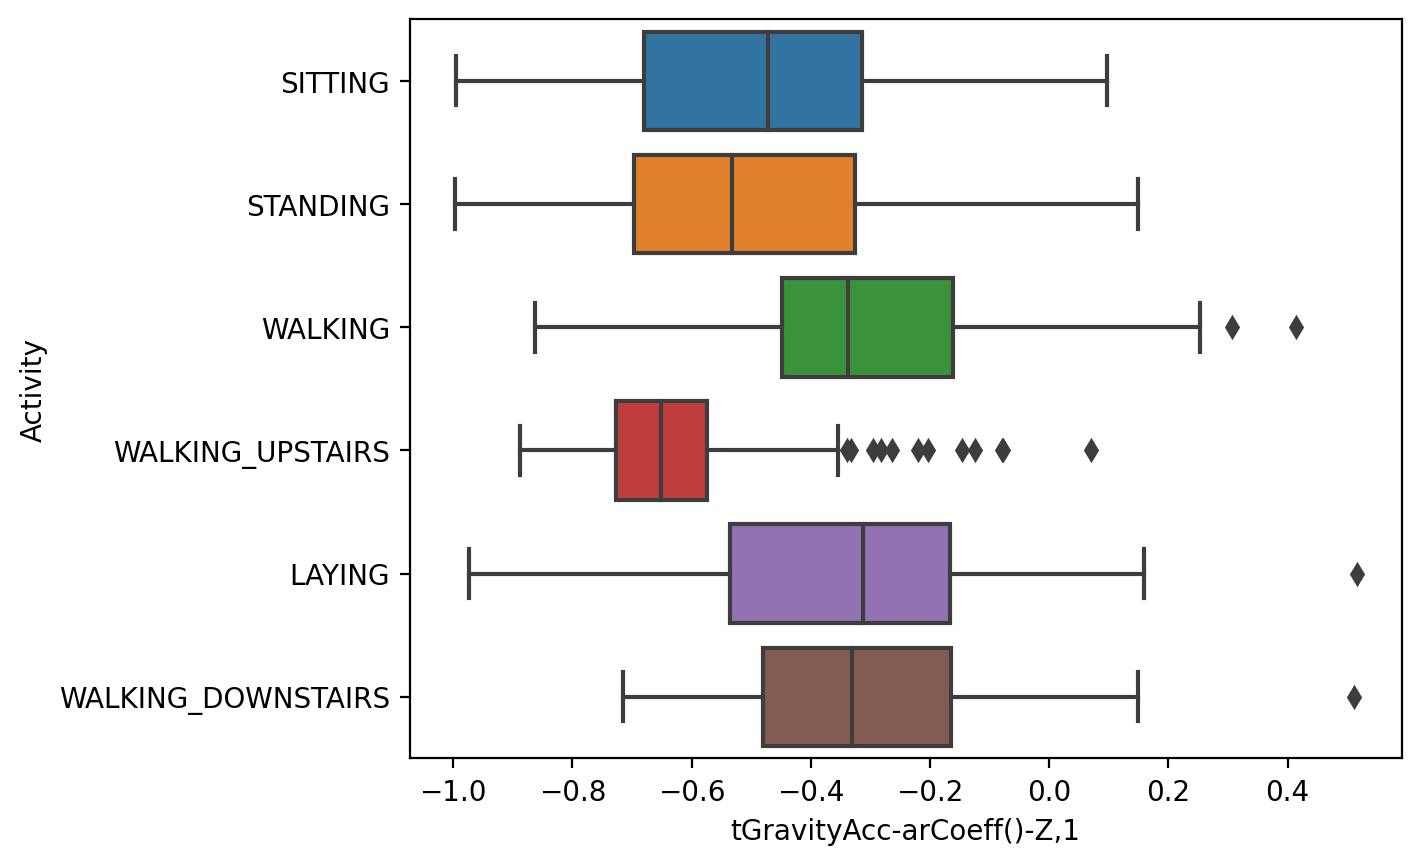

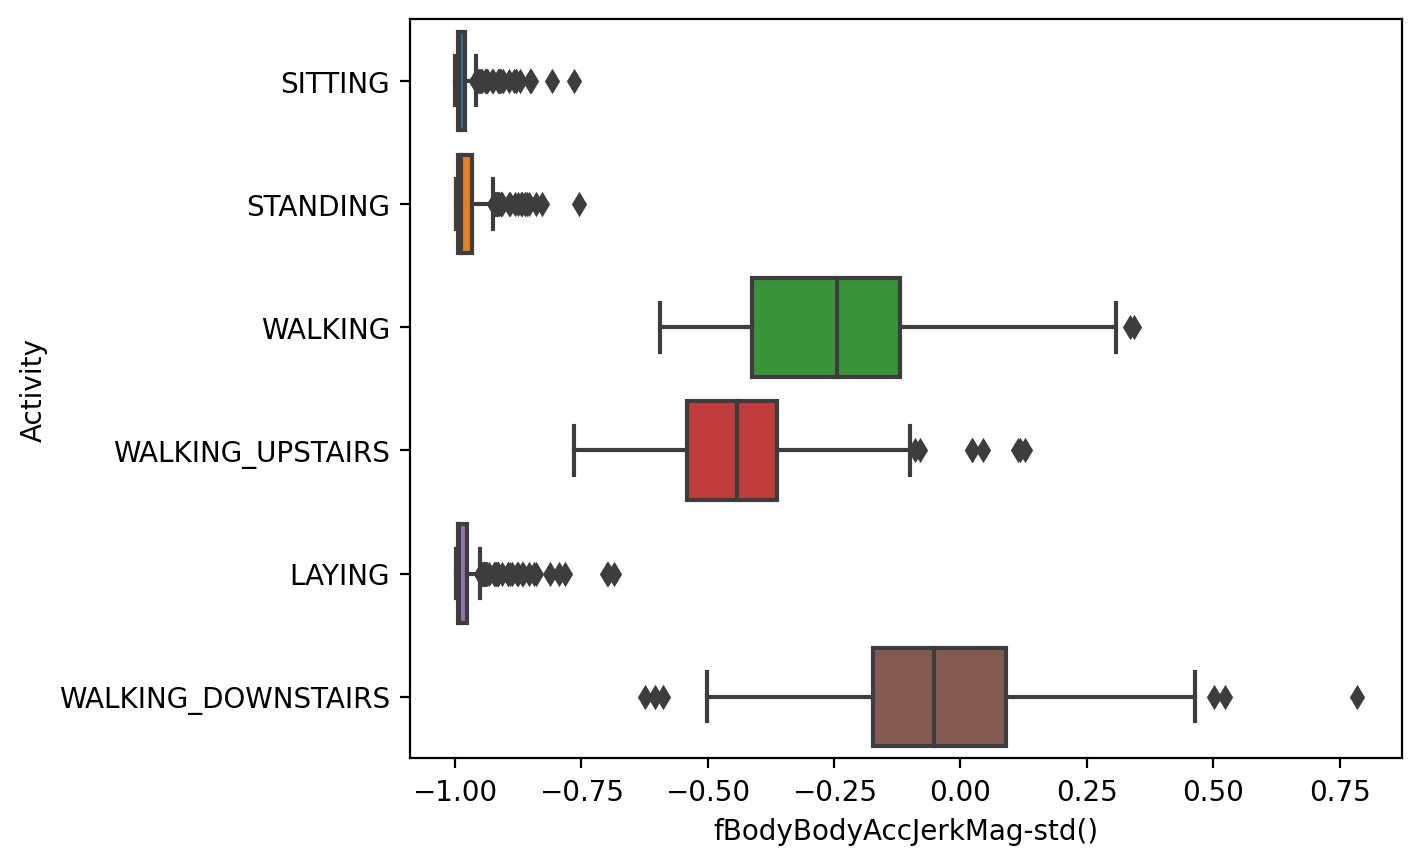

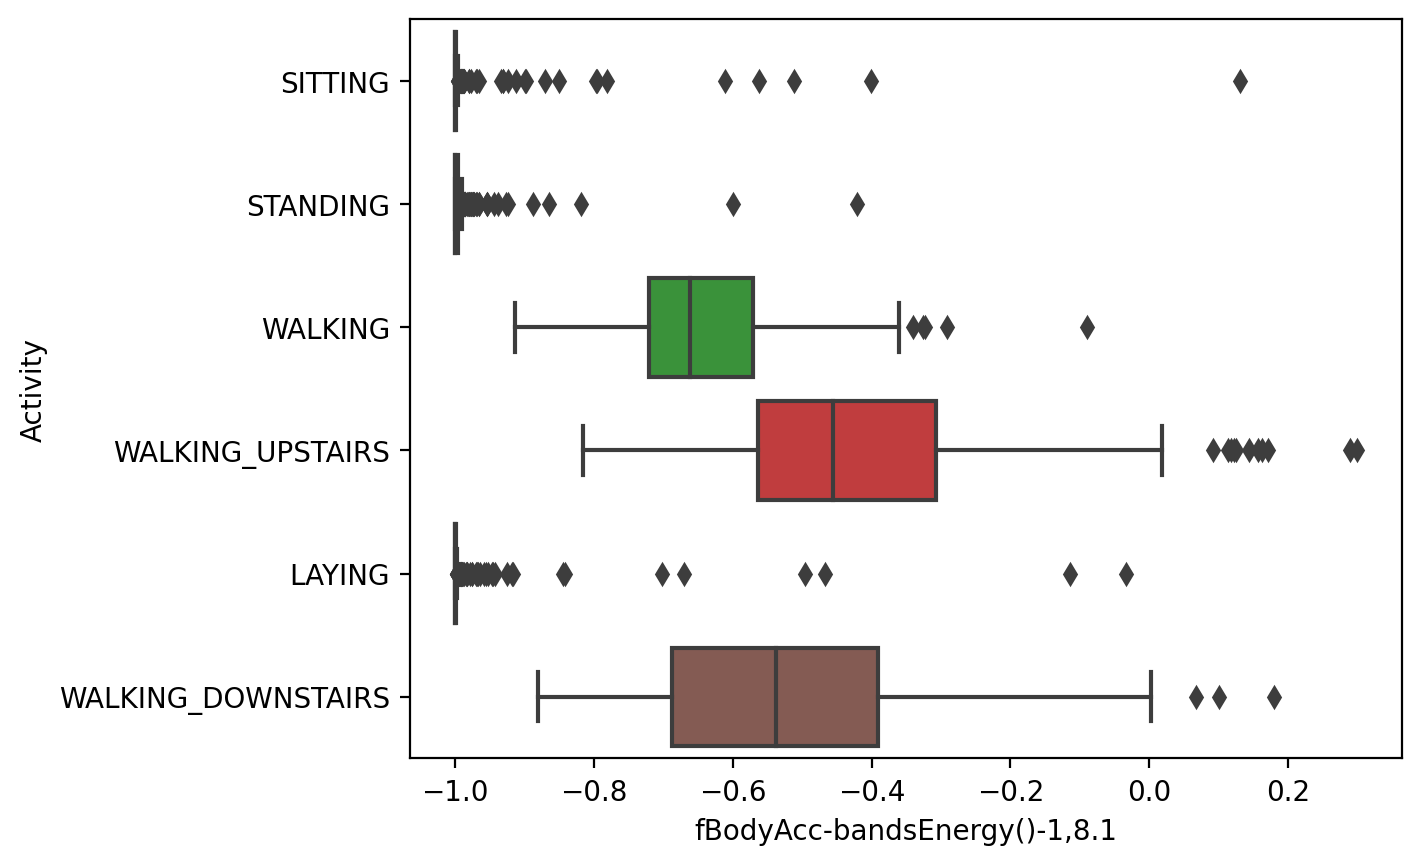

In [81]:
for i in range(0,5,):
    f_name = importance_sort['feature_name'].iloc[i]
    sns.boxplot(x=f_name, y='Activity', data=data)
    plt.show()

In [82]:
# 상위 1~5위 feature에 대한 BoxPlot 그래프 그리기



In [83]:
# 상위 1~5 순위 feature 파일로 저장
# 저장경로: ./
# 파일명: importance_result.csv



In [84]:

importance_sort_5.to_csv('importance_result.csv', index=False)



In [124]:
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING


### (4) 'WORKING_UPSTAIRS' 분류에 영향을 미치는 'sensor' 찾기
* 'WORKING_UPSTAIRS' 분류에 영향을 미치는 'sensor' 별, 'sensor + agg' 별, 'sensor 하위 agg 그룹의 누적' 그래프를 그려보세요.

	- 실습순서: 센서 데이터 불러오기 -> 데이터 프레임 merge 하기 -> sensor 별 중요도 시각화  -> agg 별 상위 20 중요도 시각화 -> sensor 별 agg 중요도 누적 그래프 시각화

* features 데이터 불러오기

In [85]:
# feature_group 변수를 생성하여 하위 data 폴더의 features.csv 데이터셋 할당
# 데이터가 잘 할당 되었나 features 데이터 확인


feature_group =pd.read_csv('./data/features.csv')
feature_group


,sensor,agg,axis,feature_name
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z
3,tBodyAcc,std(),X,tBodyAcc-std()-X
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y
...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)"
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)"
558,angle,X,gravityMean,"angle(X,gravityMean)"
559,angle,Y,gravityMean,"angle(Y,gravityMean)"


* merge_df 데이터프레임 만들기

In [86]:
# merge_df 데이터프레임 변수 생성 및 초기화
# merge_df 변수에 feature_group 데이터프레임과 importance_sort 데이터프레임을 merge 하여 할당
# 데이터가 잘 할당 되었나 merge_df 데이터 확인

merge_df = pd.DataFrame()
merge_df = pd.merge(feature_group, importance_sort)
merge_df


,sensor,agg,axis,feature_name,feature_importance
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.003518
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000119
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000000
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.000000
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000000
...,...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000221
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000000
558,angle,X,gravityMean,"angle(X,gravityMean)",0.000000
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.009788


* sensor 별 중요도 구하기

In [87]:
# sensor_sum 데이터프레임 변수 생성 및 초기화
# sensor_sum 변수를 생성하여 merge_df 변수를 'sensor' 컬럼으로 그룹화 하고 하위 feature의 'feature_importance' 데이터를 더함
# 참고함수: groupby, sum
# 잘 더해졌나 sensor_sum 데이터 확인


sensor_sum = merge_df.groupby(by='sensor')['feature_importance'].sum()
sensor_sum


sensor
angle                   0.010009
fBodyAcc                0.326182
fBodyAccJerk            0.058869
fBodyAccMag             0.000000
fBodyBodyAccJerkMag     0.093512
fBodyBodyGyroJerkMag    0.000255
fBodyBodyGyroMag        0.000082
fBodyGyro               0.032062
tBodyAcc                0.101351
tBodyAccJerk            0.017078
tBodyAccJerkMag         0.095771
tBodyAccMag             0.034330
tBodyGyro               0.053061
tBodyGyroJerk           0.001774
tBodyGyroJerkMag        0.000000
tBodyGyroMag            0.000000
tGravityAcc             0.173749
tGravityAccMag          0.000000
Name: feature_importance, dtype: float32

In [88]:
# 강사




In [89]:
# sensor_sort 변수를 생성하여 sensor_sum 데이터를 'feature_importance' 기준으로 내림차순 정렬 후 할당
# 참고함수: sort_values
# 파라미터: ascending=False
# 잘 정렬 되었는지 sensor_sort 데이터 확인

sensor_sort = sensor_sum.sort_values(ascending=False)
sensor_sort

# sensor_sort가 데이터프레임 시
#sensor_sort = sensor_sum.sort_values(by='feature_importance', ascending=False)

sensor
fBodyAcc                0.326182
tGravityAcc             0.173749
tBodyAcc                0.101351
tBodyAccJerkMag         0.095771
fBodyBodyAccJerkMag     0.093512
fBodyAccJerk            0.058869
tBodyGyro               0.053061
tBodyAccMag             0.034330
fBodyGyro               0.032062
tBodyAccJerk            0.017078
angle                   0.010009
tBodyGyroJerk           0.001774
fBodyBodyGyroJerkMag    0.000255
fBodyBodyGyroMag        0.000082
tBodyGyroJerkMag        0.000000
tBodyGyroMag            0.000000
fBodyAccMag             0.000000
tGravityAccMag          0.000000
Name: feature_importance, dtype: float32

In [90]:
# 원본


* sensor 중요도 시각화

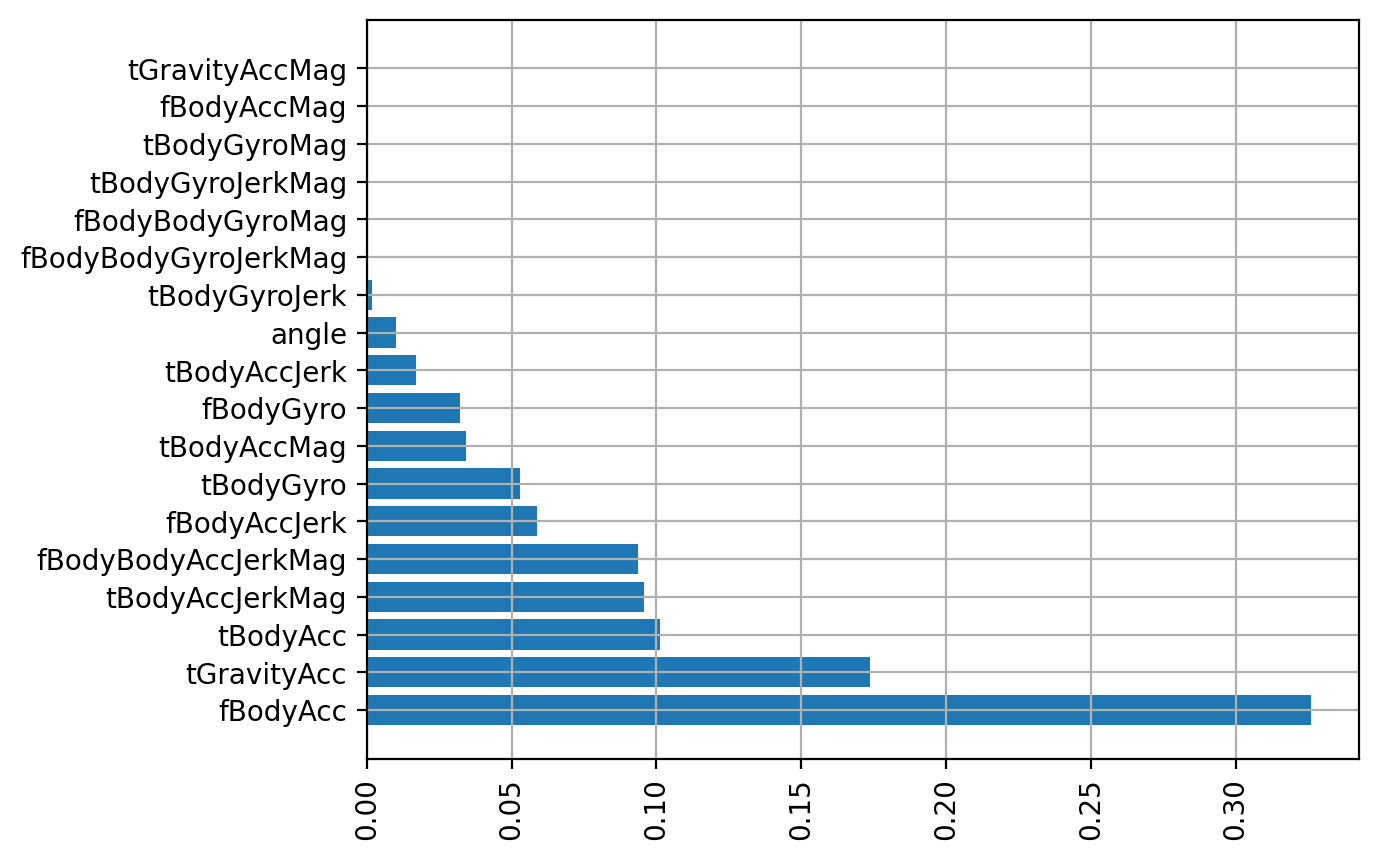

In [91]:
# pandas의 plot 함수을 사용하여 sensor 별 중요도 시각화
# 참고함수: barh

plt.barh(y=sensor_sort.index, width=sensor_sort)
plt.xticks(rotation = 90)
plt.grid()
plt.show()

# sensor_sort가 데이터프레임 시
# plt.barh(y=sensor_sort.index, width='feature_importance', data = sensor_sort)
# plt.xticks(rotation = 90, )
# plt.grid()
# plt.show()

In [92]:
# 원본

* agg 별 상위 20 중요도 시각화

In [93]:
# sensor_agg_sum 변수에 merge_df 변수를 ['sensor','agg'] 컬럼으로 그룹화 하고 하위 feature의  'feature_importance' 데이터를 더함

sensor_agg_sum = merge_df.groupby(['sensor','agg'])['feature_importance'].sum()
sensor_agg_sum

sensor          agg             
angle           X                   0.000000
                Y                   0.009788
                Z                   0.000000
                tBodyAccJerkMean    0.000000
                tBodyAccMean        0.000000
                                      ...   
tGravityAccMag  max()               0.000000
                mean()              0.000000
                min()               0.000000
                sma()               0.000000
                std()               0.000000
Name: feature_importance, Length: 221, dtype: float32

In [94]:

sensor_agg_sort = sensor_agg_sum.sort_values(ascending=False)
sensor_agg_sort

sensor               agg          
fBodyAcc             bandsEnergy()    0.255391
tGravityAcc          arCoeff()        0.125696
tBodyAccJerkMag      mad()            0.094476
fBodyBodyAccJerkMag  std()            0.075896
tBodyAcc             correlation()    0.069914
                                        ...   
fBodyBodyGyroMag     min()            0.000000
                     skewness()       0.000000
                     sma()            0.000000
                     std()            0.000000
tGravityAccMag       std()            0.000000
Name: feature_importance, Length: 221, dtype: float32

In [95]:
# 원본



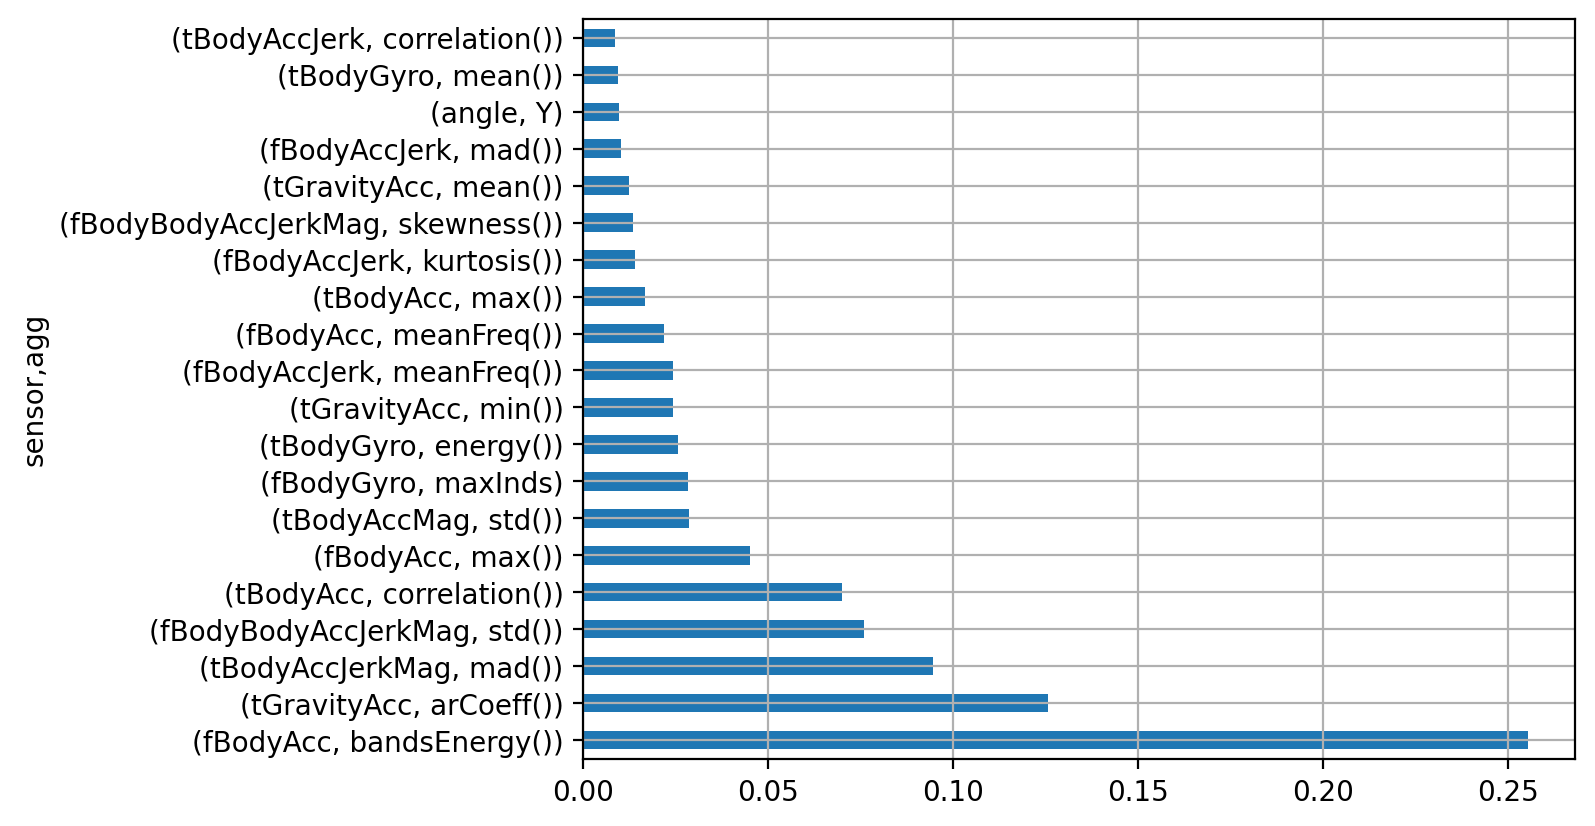

In [96]:
# pandas의 plot 함수을 사용하여 sensor_agg_sort를 sensor 별 중요도 상위 20개만 시각화
# 참고함수: 변수명.plot
# 파라미터: kind='barh'

sensor_agg_sort[:20].plot(kind='barh')
plt.grid()
plt.show()

In [97]:
#원본


* sensor 별 agg 중요도 누적 그래프 시각화

In [98]:
# acc변수에 sensor_agg_sort 변수의 'agg' 인덱스를 컬럼으로 변환(재구조화) 후 할당
# 참고함수: unstack()

acc = sensor_agg_sort.unstack()
acc


agg,X,Y,Z,arCoeff(),arCoeff()1,arCoeff()2,arCoeff()3,arCoeff()4,bandsEnergy(),correlation(),...,mean(),meanFreq(),min(),skewness(),sma(),std(),tBodyAccJerkMean,tBodyAccMean,tBodyGyroJerkMean,tBodyGyroMean
sensor,,,,,,,,,,,,,,,,,,,,,
angle,0.0,0.009788,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.000221
fBodyAcc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.255391,NaN,...,0.000000,0.021762,0.000000,0.002543,0.0,0.000000,NaN,NaN,NaN,NaN
fBodyAccJerk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003128,NaN,...,0.000000,0.024183,0.000000,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN
fBodyAccMag,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN
fBodyBodyAccJerkMag,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.013504,0.0,0.075896,NaN,NaN,NaN,NaN
fBodyBodyGyroJerkMag,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000137,0.0,0.000000,NaN,NaN,NaN,NaN
fBodyBodyGyroMag,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN
fBodyGyro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,...,0.000000,0.000000,0.000000,0.000299,0.0,0.000126,NaN,NaN,NaN,NaN
tBodyAcc,NaN,NaN,NaN,0.005098,NaN,NaN,NaN,NaN,NaN,0.069914,...,0.003637,NaN,0.000000,NaN,0.0,0.000000,NaN,NaN,NaN,NaN


In [99]:

acc['sort'] = acc.sum(axis=1)
acc.sort_values(by = 'sort', ascending = False, inplace=True)
acc


agg,X,Y,Z,arCoeff(),arCoeff()1,arCoeff()2,arCoeff()3,arCoeff()4,bandsEnergy(),correlation(),...,meanFreq(),min(),skewness(),sma(),std(),tBodyAccJerkMean,tBodyAccMean,tBodyGyroJerkMean,tBodyGyroMean,sort
sensor,,,,,,,,,,,,,,,,,,,,,
fBodyAcc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.255391,NaN,...,0.021762,0.000000,0.002543,0.0,0.000000,NaN,NaN,NaN,NaN,0.326182
tGravityAcc,NaN,NaN,NaN,0.125696,NaN,NaN,NaN,NaN,NaN,0.000000,...,NaN,0.024362,NaN,0.0,0.002605,NaN,NaN,NaN,NaN,0.173749
tBodyAcc,NaN,NaN,NaN,0.005098,NaN,NaN,NaN,NaN,NaN,0.069914,...,NaN,0.000000,NaN,0.0,0.000000,NaN,NaN,NaN,NaN,0.101351
tBodyAccJerkMag,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,NaN,0.000000,NaN,0.0,0.000000,NaN,NaN,NaN,NaN,0.095771
fBodyBodyAccJerkMag,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.013504,0.0,0.075896,NaN,NaN,NaN,NaN,0.093512
fBodyAccJerk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003128,NaN,...,0.024183,0.000000,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN,0.058869
tBodyGyro,NaN,NaN,NaN,0.003267,NaN,NaN,NaN,NaN,NaN,0.001205,...,NaN,0.000000,NaN,0.0,0.000000,NaN,NaN,NaN,NaN,0.053061
tBodyAccMag,NaN,NaN,NaN,NaN,0.000175,0.000259,0.002257,0.0,NaN,NaN,...,NaN,0.000000,NaN,0.0,0.028558,NaN,NaN,NaN,NaN,0.034330
fBodyGyro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,...,0.000000,0.000000,0.000299,0.0,0.000126,NaN,NaN,NaN,NaN,0.032062


In [100]:
# 정렬을 완료 했으므로 acc 변수에서 # acc['sort']열 삭제
# 참고함수: drop()

acc.drop('sort', axis=1, inplace=True)
acc


agg,X,Y,Z,arCoeff(),arCoeff()1,arCoeff()2,arCoeff()3,arCoeff()4,bandsEnergy(),correlation(),...,mean(),meanFreq(),min(),skewness(),sma(),std(),tBodyAccJerkMean,tBodyAccMean,tBodyGyroJerkMean,tBodyGyroMean
sensor,,,,,,,,,,,,,,,,,,,,,
fBodyAcc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.255391,NaN,...,0.000000,0.021762,0.000000,0.002543,0.0,0.000000,NaN,NaN,NaN,NaN
tGravityAcc,NaN,NaN,NaN,0.125696,NaN,NaN,NaN,NaN,NaN,0.000000,...,0.012382,NaN,0.024362,NaN,0.0,0.002605,NaN,NaN,NaN,NaN
tBodyAcc,NaN,NaN,NaN,0.005098,NaN,NaN,NaN,NaN,NaN,0.069914,...,0.003637,NaN,0.000000,NaN,0.0,0.000000,NaN,NaN,NaN,NaN
tBodyAccJerkMag,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,0.000000,NaN,0.000000,NaN,0.0,0.000000,NaN,NaN,NaN,NaN
fBodyBodyAccJerkMag,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.013504,0.0,0.075896,NaN,NaN,NaN,NaN
fBodyAccJerk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003128,NaN,...,0.000000,0.024183,0.000000,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN
tBodyGyro,NaN,NaN,NaN,0.003267,NaN,NaN,NaN,NaN,NaN,0.001205,...,0.009406,NaN,0.000000,NaN,0.0,0.000000,NaN,NaN,NaN,NaN
tBodyAccMag,NaN,NaN,NaN,NaN,0.000175,0.000259,0.002257,0.0,NaN,NaN,...,0.000000,NaN,0.000000,NaN,0.0,0.028558,NaN,NaN,NaN,NaN
fBodyGyro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,...,0.000000,0.000000,0.000000,0.000299,0.0,0.000126,NaN,NaN,NaN,NaN


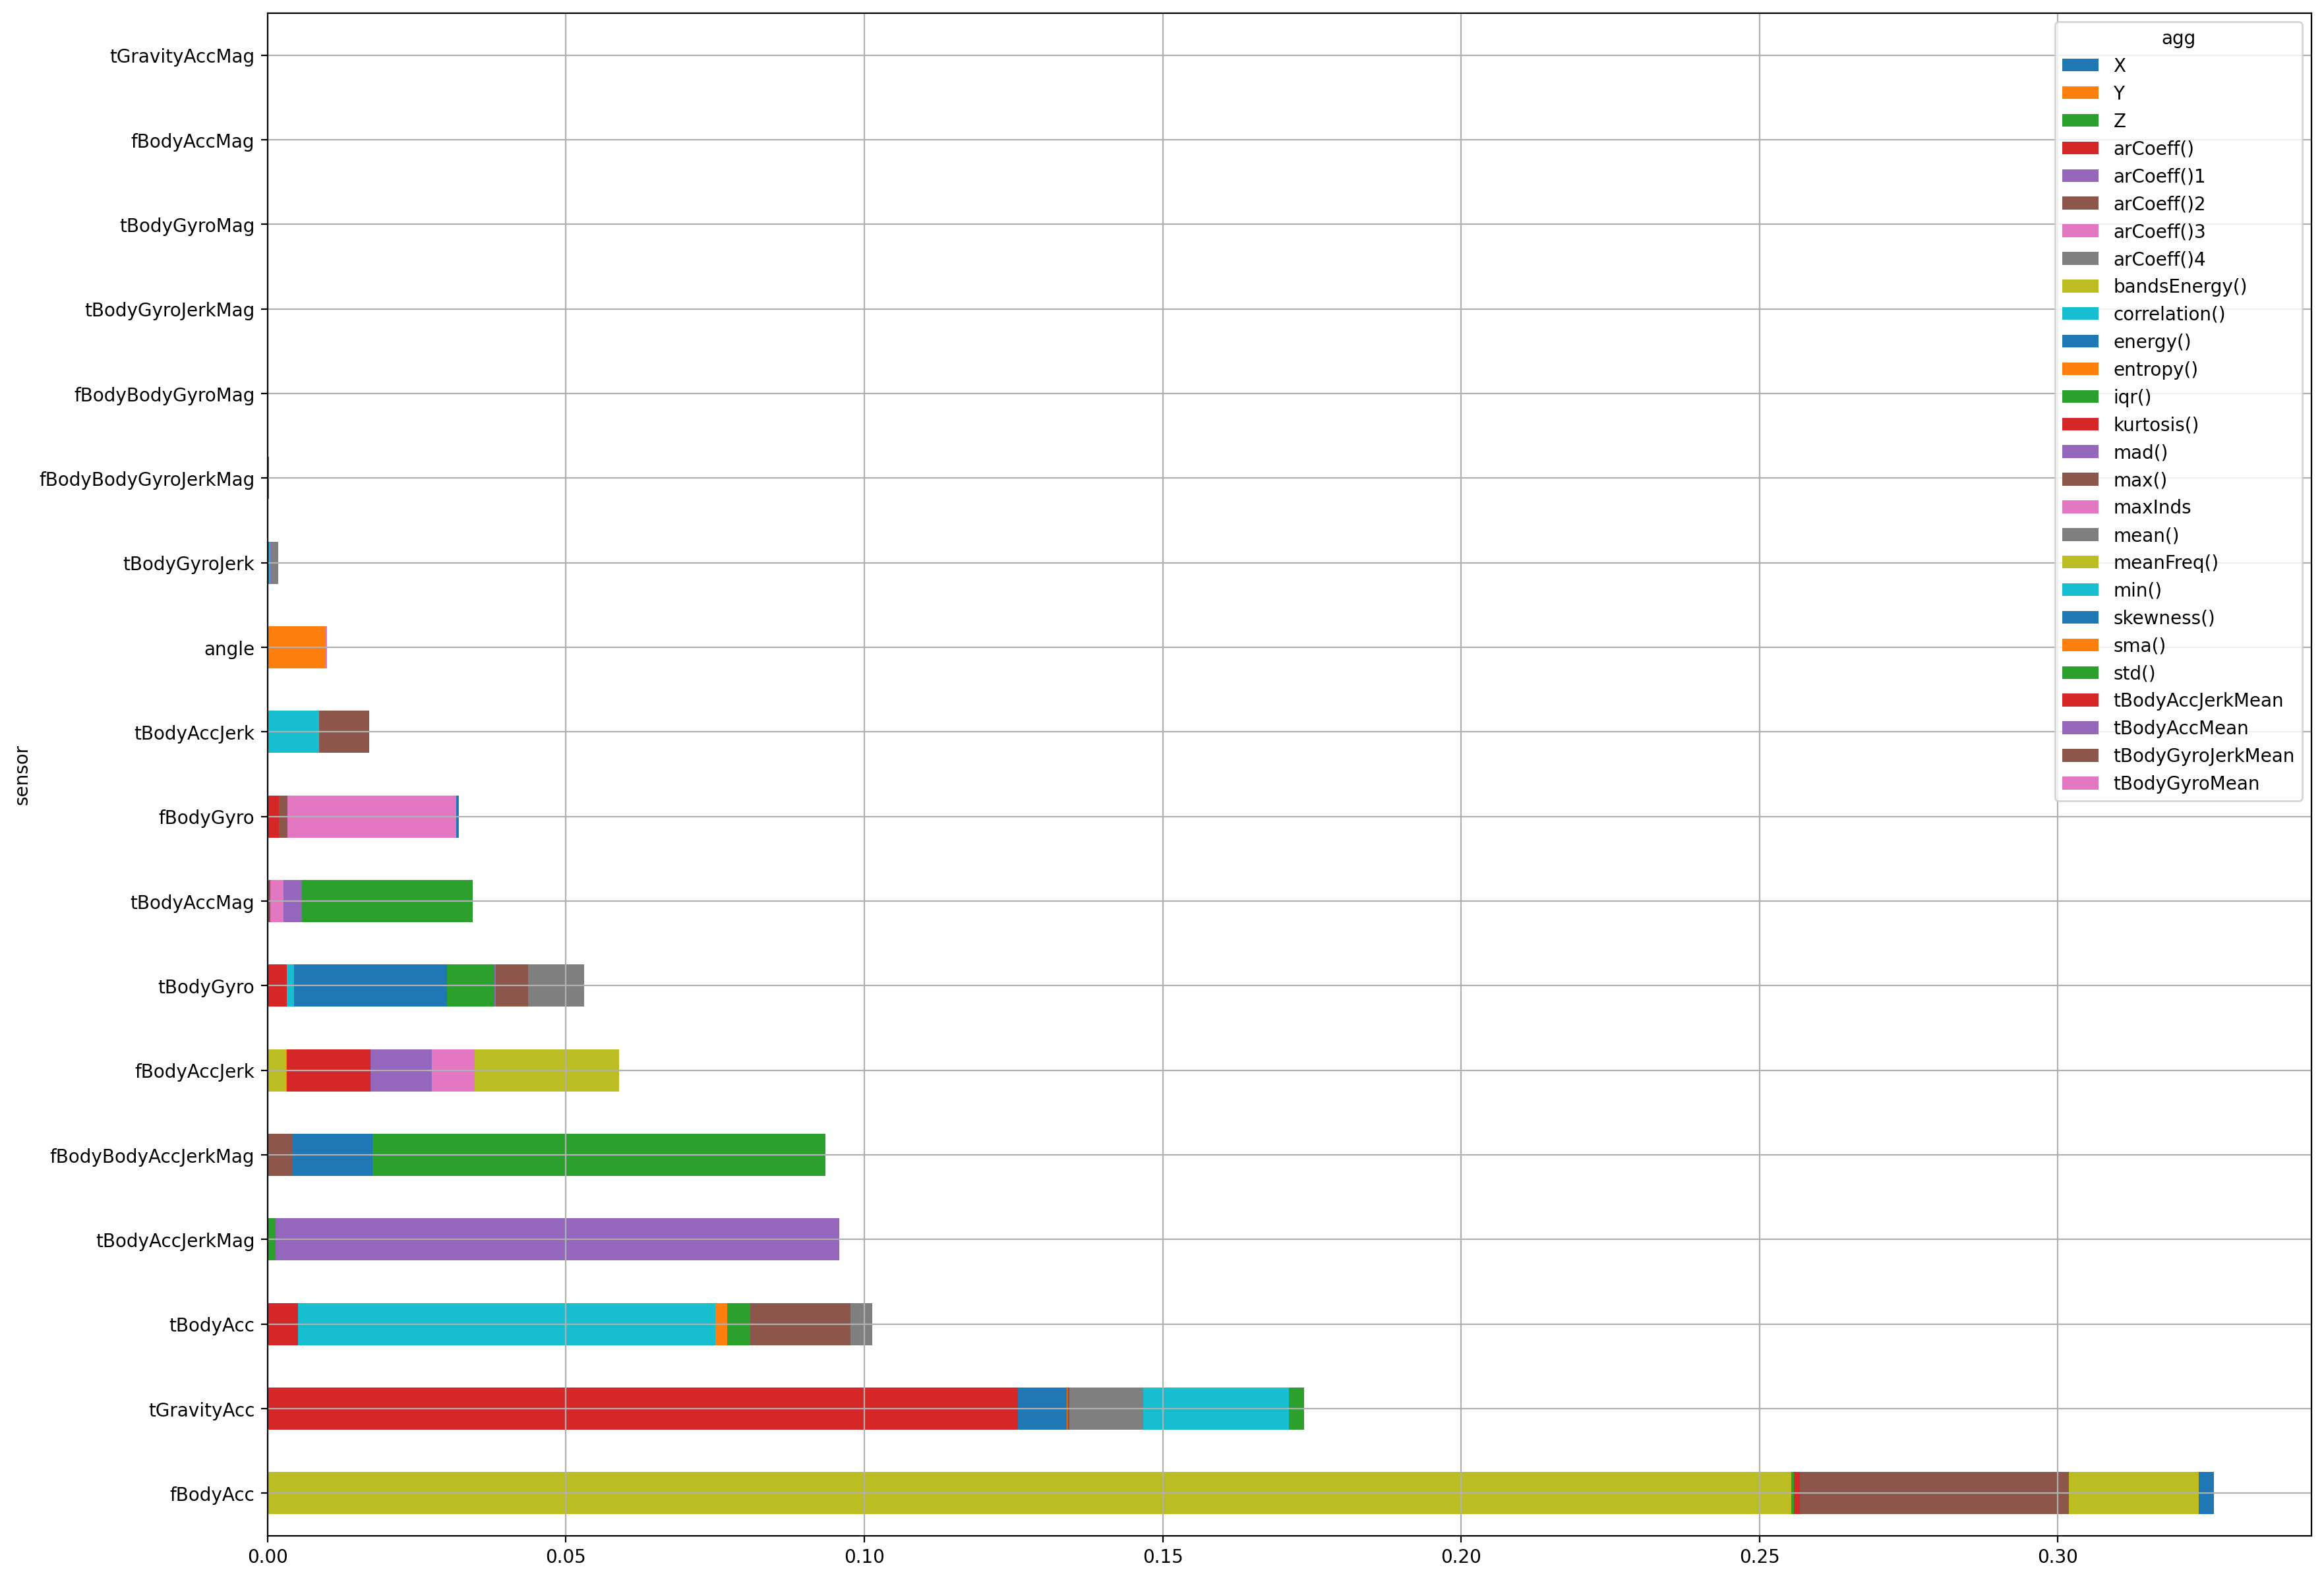

In [101]:
# pandas의 plot 함수을 사용하여 acc를 sensor 별 agg 누적 수평그래프로 시각화
# 참고함수: 변수명.plot
# 파라미터: kind='barh', stacked=True, figsize=(20,15)


acc.plot(kind='barh', stacked=True, figsize=(20,15))
plt.grid()
plt.show()


In [102]:
# pandas의 plot 함수을 사용하여 acc를 sensor 별 agg 누적 수평그래프로 시각화
# 참고함수: 변수명.plot
# 파라미터: kind='barh', stacked=True, figsize=(20,15)

* 결과 저장

In [103]:
result_comp = result.set_index(['data','model_name'])
result_comp

accuracy_score  f1_score
data  model_name                             
train svc                  0.968839  0.971715
      KNN                  0.954674  0.958345
      LR                   0.983003  0.984583
      GBM                  0.981870  0.983141
      xgb                  0.990368  0.991052
      xgb_hpt              0.991501  0.992355
      xgb95_hpt            0.992068  0.992371
      xgb50_hpt            0.988669  0.988601
      xgb_top_model        0.992635  0.993060
test  xgb_hpt              0.970588  0.971003
      xgb_top_model        0.977376  0.977416
      up_xgb               0.990950  0.981963
      up_xgb_top           0.997738  0.995575

In [104]:
#원본



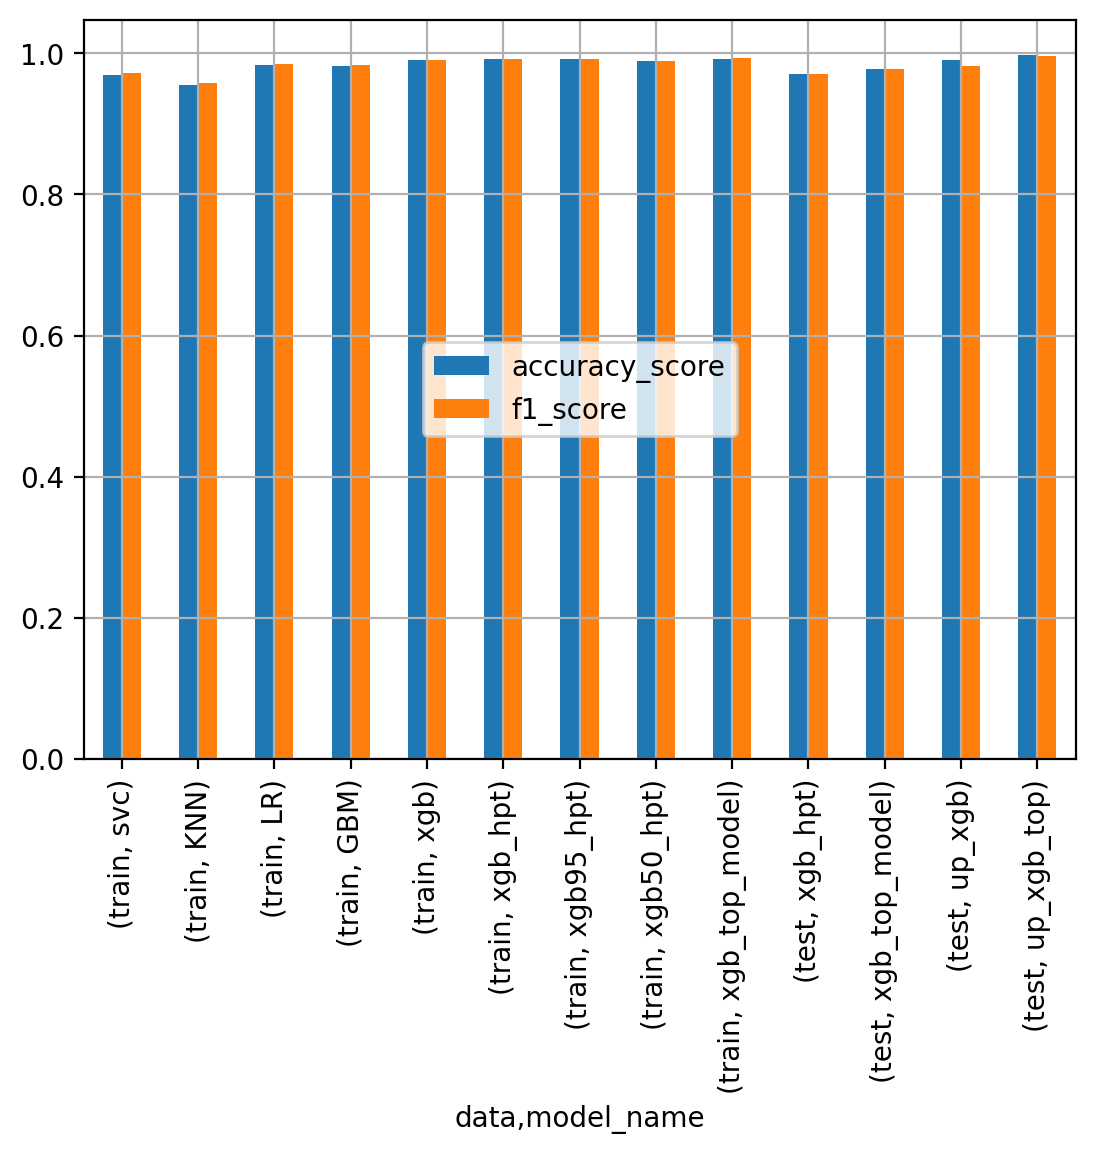

In [105]:
# pandas의 plot 함수을 사용하여 AI모델 별 accuracy_score, f1_score 수직 그래프 시각화
# grid 추가
# legend 위치 center

result_comp.plot(kind='bar')
plt.grid()
plt.legend(loc='center')
plt.show()


In [106]:
# pandas의 plot 함수을 사용하여 AI모델 별 accuracy_score, f1_score 수직 그래프 시각화
# grid 추가
# legend 위치 center



In [113]:
result_comp

accuracy_score  f1_score
data  model_name                             
train svc                  0.968839  0.971715
      KNN                  0.954674  0.958345
      LR                   0.983003  0.984583
      GBM                  0.981870  0.983141
      xgb                  0.990368  0.991052
      xgb_hpt              0.991501  0.992355
      xgb95_hpt            0.992068  0.992371
      xgb50_hpt            0.988669  0.988601
      xgb_top_model        0.992635  0.993060
test  xgb_hpt              0.970588  0.971003
      xgb_top_model        0.977376  0.977416
      up_xgb               0.990950  0.981963
      up_xgb_top           0.997738  0.995575

In [115]:
# 최종 result 데이터프레임 csv 파일로 저장
# 저장경로: ./
# 파일명: model_result.csv


result_comp.to_csv('model_result.csv')

---
---

<span style="background-color:#fff5b1"><span style="color:black"><도전미션> 단말기 개발팀에서 최근에 수집한 real 데이터를 보내 주었습니다. 이 데이터에는 Activity 정보가 없습니다. 'subject' 열 기준 몇 번이 'WALKING_UPSTAIRS' 데이터인지 분류해서 단말기 개발팀에 보내 주세요.</span></span>

* Activity 표기가 없는 실제 데이터를 사용한 분류 예측

In [119]:
# real_data.csv 파일을 불러와서 real_all 변수에 할당
# 잘 할당 되었는지 상위 5개행 데이터 확인
real_all = pd.read_csv('real_data.csv')
real_all.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
0,0.064073,-0.005123,-0.271555,-0.231952,0.593444,0.833666,-0.293844,0.603777,0.906303,-0.203098,...,-0.317461,-0.703020,0.075952,-0.648670,-0.838078,0.407393,-0.327642,0.312526,0.431085,1
1,-0.239103,-0.096904,0.148035,-0.637325,-0.127692,-0.258924,-0.643642,-0.138551,-0.239634,-0.878149,...,-0.157009,-0.561918,0.002418,-0.002366,-0.101878,0.543207,0.378792,-0.488443,-0.487057,2
2,-0.181394,0.324130,0.129390,-0.867258,-0.581496,-0.777242,-0.885160,-0.575035,-0.748065,-0.971348,...,-0.528134,-0.884218,0.106616,0.579102,0.082680,-0.075495,-0.638803,-0.024623,-0.208879,3
3,-0.166426,-0.119353,0.133035,-0.633135,-0.189775,-0.319336,-0.623804,-0.199675,-0.281088,-0.925208,...,0.196038,-0.128895,0.139475,0.039216,-0.495303,0.082696,0.272083,-0.534122,-0.397428,4
4,-0.161088,-0.028160,-0.209931,0.817104,0.873037,0.127390,0.734566,0.845695,0.111837,0.803192,...,-0.609554,-0.864934,0.621322,-0.820087,0.351063,0.193917,-0.729349,0.208647,0.174249,5


In [109]:
# real_fil 변수에 real_all 변수(데이터셋)에서 행동분류에 불필요한 'subject'열 제거한 데이터 할당
# 'subject'열이 잘 제거 되었는지 확인
# 나중에 예측 결과를 real_all 데이터 프레임 병합 해야 하므로 real_all 에서 'subject'열 제거하지 말것
real_fil = pd.read_csv('real_data.csv')

real_fil.drop('subject', axis=True, inplace=True)

real_fil.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.064073,-0.005123,-0.271555,-0.231952,0.593444,0.833666,-0.293844,0.603777,0.906303,-0.203098,...,-0.046164,-0.317461,-0.703020,0.075952,-0.648670,-0.838078,0.407393,-0.327642,0.312526,0.431085
1,-0.239103,-0.096904,0.148035,-0.637325,-0.127692,-0.258924,-0.643642,-0.138551,-0.239634,-0.878149,...,-0.691219,-0.157009,-0.561918,0.002418,-0.002366,-0.101878,0.543207,0.378792,-0.488443,-0.487057
2,-0.181394,0.324130,0.129390,-0.867258,-0.581496,-0.777242,-0.885160,-0.575035,-0.748065,-0.971348,...,-0.206895,-0.528134,-0.884218,0.106616,0.579102,0.082680,-0.075495,-0.638803,-0.024623,-0.208879
3,-0.166426,-0.119353,0.133035,-0.633135,-0.189775,-0.319336,-0.623804,-0.199675,-0.281088,-0.925208,...,-0.800684,0.196038,-0.128895,0.139475,0.039216,-0.495303,0.082696,0.272083,-0.534122,-0.397428
4,-0.161088,-0.028160,-0.209931,0.817104,0.873037,0.127390,0.734566,0.845695,0.111837,0.803192,...,0.458379,-0.609554,-0.864934,0.621322,-0.820087,0.351063,0.193917,-0.729349,0.208647,0.174249


In [110]:
# x_real_top 변수에 학습에 필요한 Feature Slection 이 적용된 x_real 변수 할당
# Feature Select 된 상위 중요 feature 리스트는 importance_top 변수 사용

x_real_top = real_fil[importance_top]

In [111]:
x_real_top.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 52 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   fBodyAcc-bandsEnergy()-1,8.2    30 non-null     float64
 1   tBodyAccJerkMag-mad()           30 non-null     float64
 2   tGravityAcc-arCoeff()-Z,1       30 non-null     float64
 3   fBodyBodyAccJerkMag-std()       30 non-null     float64
 4   fBodyAcc-bandsEnergy()-1,8.1    30 non-null     float64
 5   tBodyAcc-correlation()-X,Y      30 non-null     float64
 6   tBodyAccMag-std()               30 non-null     float64
 7   fBodyGyro-maxInds-Z             30 non-null     float64
 8   fBodyAcc-max()-Z                30 non-null     float64
 9   tBodyGyro-energy()-X            30 non-null     float64
 10  tGravityAcc-arCoeff()-Y,2       30 non-null     float64
 11  tGravityAcc-min()-Y             30 non-null     float64
 12  fBodyAcc-max()-X                30 non

In [112]:
# 위에서 생성해 놓은 up_xgb_top_model 모델으로 x_real_top 데이터의 'WALKING_UPSTAIRS' 행동분류 예측
# 예측결과 변수명: xgb_real_top_pred
# random_state=2023
xgb_real_top_pred = up_xgb_top_model.predict(x_real_top)
xgb_real_top_pred

array([1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0])

In [125]:
# real_all['ativity'] 열에 up_xgb_top_pred 예측 결과를 할당
real_all['WALKING_UPSTAIRS'] = xgb_real_top_pred


In [127]:
# 인덱스 미포함 real_all 변수를 real_result.csv 파일로 저장
# 저장경로: ./
# 파일명: real_result.csv

real_all.to_csv('real_result.csv')

In [128]:
# 저장 확인

real_result = pd.read_csv('real_result.csv')
real_result

,Unnamed: 0,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,WALKING_UPSTAIRS
0,0,0.064073,-0.005123,-0.271555,-0.231952,0.593444,0.833666,-0.293844,0.603777,0.906303,...,-0.703020,0.075952,-0.648670,-0.838078,0.407393,-0.327642,0.312526,0.431085,1,1
1,1,-0.239103,-0.096904,0.148035,-0.637325,-0.127692,-0.258924,-0.643642,-0.138551,-0.239634,...,-0.561918,0.002418,-0.002366,-0.101878,0.543207,0.378792,-0.488443,-0.487057,2,0
2,2,-0.181394,0.324130,0.129390,-0.867258,-0.581496,-0.777242,-0.885160,-0.575035,-0.748065,...,-0.884218,0.106616,0.579102,0.082680,-0.075495,-0.638803,-0.024623,-0.208879,3,0
3,3,-0.166426,-0.119353,0.133035,-0.633135,-0.189775,-0.319336,-0.623804,-0.199675,-0.281088,...,-0.128895,0.139475,0.039216,-0.495303,0.082696,0.272083,-0.534122,-0.397428,4,0
4,4,-0.161088,-0.028160,-0.209931,0.817104,0.873037,0.127390,0.734566,0.845695,0.111837,...,-0.864934,0.621322,-0.820087,0.351063,0.193917,-0.729349,0.208647,0.174249,5,0
5,5,-0.107530,0.013312,1.000000,-0.835146,-0.600036,-0.356636,-0.836418,-0.550924,-0.307091,...,-0.709580,0.142569,0.612084,-0.078512,0.002076,0.355207,-0.783544,0.169957,6,0
6,6,0.058595,-0.050059,-0.167108,-0.223698,0.110078,-0.094274,-0.248771,0.062721,-0.119843,...,-0.801206,0.368073,0.435915,-0.935362,-0.041572,-0.506027,0.364035,0.229471,7,1
7,7,0.062631,-0.062839,-0.334600,-0.170677,-0.365133,0.099516,-0.210948,-0.404148,0.103444,...,-0.149349,0.041817,0.121594,0.967539,-0.117698,-0.536821,0.207750,0.328708,8,1
8,8,0.069324,-0.007338,-0.161523,-0.090053,0.000301,0.243752,-0.232309,-0.026293,0.034870,...,-0.476123,0.669298,0.037212,0.906914,0.502852,-0.827640,0.155705,0.127148,9,0
9,9,-0.466440,-0.618098,0.948795,-0.789764,-0.057348,-0.352774,-0.803030,0.063835,-0.302126,...,-0.728500,0.166498,0.611890,-0.002655,-0.018370,0.694861,-0.692058,-0.297937,10,0


---
---

### (5) 결과 메일 발송

* 수신자: aivleschool.dx@gmail.com
* 발송기한: 15시20분 까지